In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load Data
data_file = "/content/drive/MyDrive/E-commerce_data.xlsx"
customers = pd.read_excel(data_file, sheet_name="customers")
genders = pd.read_excel(data_file, sheet_name="genders")
cities = pd.read_excel(data_file, sheet_name="cities")
transactions = pd.read_excel(data_file, sheet_name="transactions")
branches = pd.read_excel(data_file, sheet_name="branches")
merchants = pd.read_excel(data_file, sheet_name="merchants")


In [2]:
# Merge tables to make it one data
customers = customers.merge(genders, on="gender_id", how="left")
customers = customers.merge(cities, on="city_id", how="left")
transactions = transactions.merge(customers, on="customer_id", how="left")
transactions = transactions.merge(branches, on="branch_id", how="left")
transactions = transactions.merge(merchants, on="merchant_id", how="left")


In [3]:
# Convert dates
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
transactions['burn_date'] = pd.to_datetime(transactions['burn_date'])
transactions['time_to_burn'] = (transactions['burn_date'] - transactions['transaction_date']).dt.days

# Fill missing values with the column mean
transactions['time_to_burn'].fillna(transactions['time_to_burn'].mean(), inplace=True)

<ipython-input-3-b84a4d06de74>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transactions['time_to_burn'].fillna(transactions['time_to_burn'].mean(), inplace=True)


In [4]:
# Aggregate transaction-level data to customer-level data
customer_features = transactions.groupby("customer_id").agg({
    "transaction_id": "count",
    "time_to_burn": "mean",
    "transaction_status": lambda x: (x == "burned").mean(),
    "city_name": "first",
    "gender_name": "first"
}).reset_index()

customer_features.rename(columns={
    "transaction_id": "transaction_count",
    "time_to_burn": "avg_time_to_burn",
    "transaction_status": "burn_ratio"
}, inplace=True)


In [5]:
# Encode categorical variables to numerical variables
label_encoder = LabelEncoder()
customer_features['city_name'] = label_encoder.fit_transform(customer_features['city_name'])
customer_features['gender_name'] = label_encoder.fit_transform(customer_features['gender_name'])

# Drop customer_id for clustering
X = customer_features.drop(columns=["customer_id"])

In [6]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

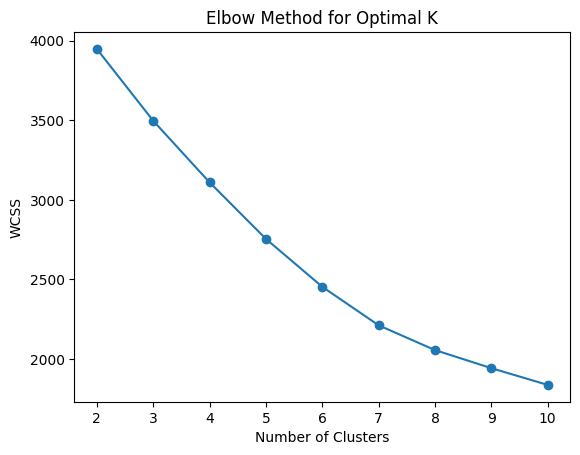

In [7]:
# Find optimal clusters using Elbow Method
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()


In [8]:
# Train K-Means Model
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_features['cluster'] = kmeans.fit_predict(X_scaled)



Silhouette Score: 0.222


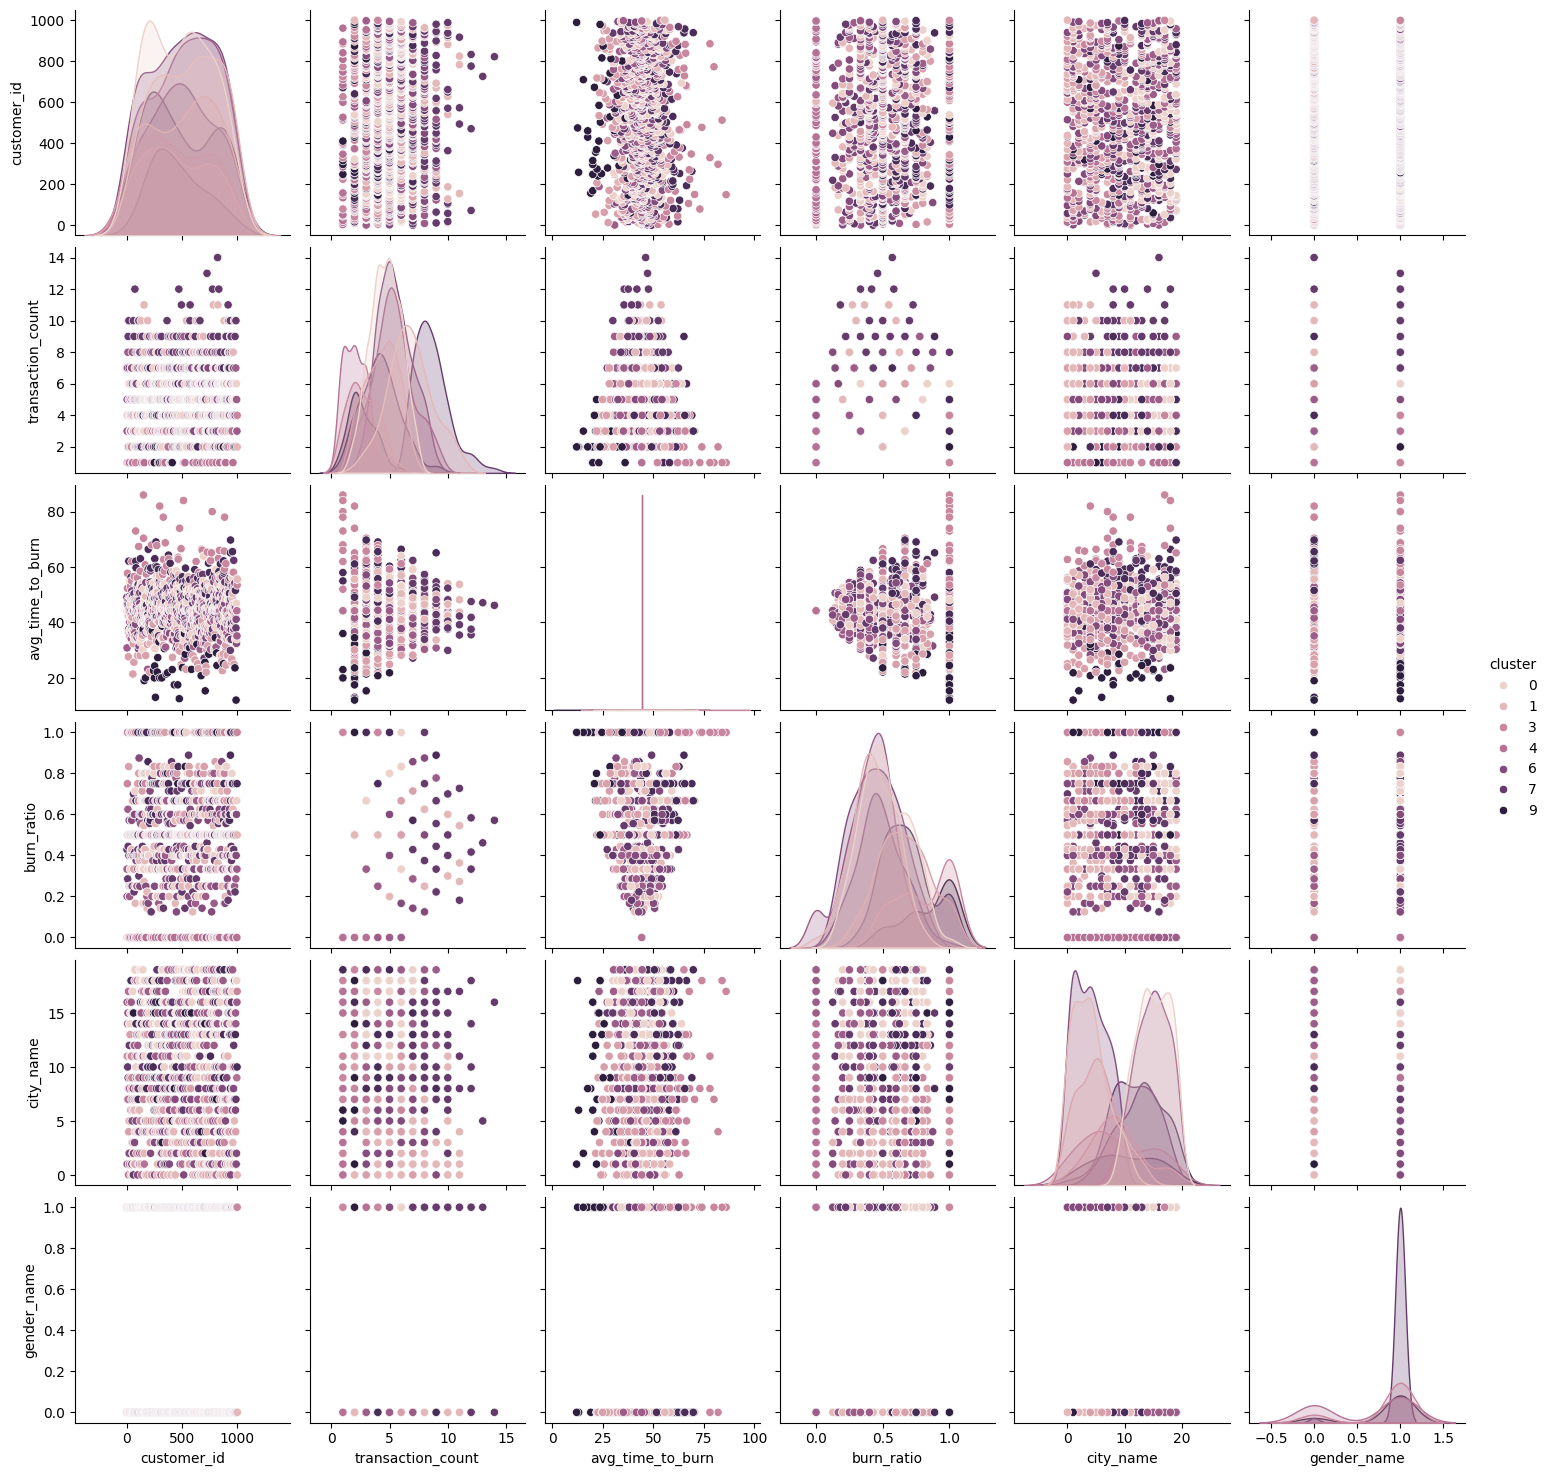

         customer_id  transaction_count  avg_time_to_burn  burn_ratio  \
cluster                                                                 
0         484.638298           4.659574         45.044699    0.519723   
1         544.709677           6.758065         45.930129    0.437077   
2         505.442105           4.305263         33.621429    0.661429   
3         455.766667           2.750000         61.734287    0.808333   
4         443.565217           2.130435         44.232512    0.000000   
5         529.446970           5.272727         40.905103    0.408550   
6         510.440559           5.454545         44.525462    0.460157   
7         499.010417           8.625000         44.533228    0.483852   
8         494.136364           4.215909         54.113120    0.679500   
9         464.609756           2.658537         25.830008    0.844715   

         city_name  gender_name  
cluster                          
0        14.921986     1.000000  
1         3.862903   

In [9]:
# Evaluate clustering quality
silhouette_avg = silhouette_score(X_scaled, customer_features['cluster'])
print(f'Silhouette Score: {silhouette_avg:.3f}')

# Visualize Clusters
sns.pairplot(customer_features, hue='cluster', diag_kind='kde')
plt.show()

# Cluster Profiling
print(customer_features.groupby("cluster").mean())


for cluster_id in range(optimal_k):
    segment = customer_features[customer_features['cluster'] == cluster_id]
    print(f"Segment {cluster_id}: {len(segment)} customers")
    if segment['burn_ratio'].mean() > 0.7:
        print("-> Loyal customers: Offer exclusive coupons!")
    elif segment['transaction_count'].mean() > 10:
        print("-> High spenders: Offer VIP discounts!")
    elif segment['burn_ratio'].mean() < 0.3:
        print("-> Inactive users: Send re-engagement offers!")
    else:
        print("-> Moderate users: Provide seasonal promotions!")
